In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import pqcd

from cmcrameri import cm
from matplotlib.colors import to_rgba, to_hex, LinearSegmentedColormap
from pqcd.utils import (
    to_GeV_per_cubic_femtometre,
    to_nucleons_per_cubic_femtometre,
    nsat,
    )

from plot_utils import rcparams, prior_c, astro_c
plt.rcParams.update(rcparams)

In [2]:
crust = pd.read_csv(
    '../data/eos-draws-default/make-agnostic-processes/'
    'ingo-bps-with-cs2c2-modified.csv'
)

crust_pressure = to_GeV_per_cubic_femtometre(crust.pressurec2)
crust_energy_density = to_GeV_per_cubic_femtometre(crust.energy_densityc2)
crust_number_density = to_nucleons_per_cubic_femtometre(crust.baryon_density)
crust_chemical_potential = (crust_energy_density+crust_pressure)/crust_number_density

p_ref = to_GeV_per_cubic_femtometre(3e11)
p_ref_index = np.argmin(abs(crust_pressure-p_ref))

pL = crust_pressure[p_ref_index]
muL = crust_chemical_potential[p_ref_index]
nL = crust_number_density[p_ref_index]

In [3]:
L_c = cm.roma(0.8)
H_c = cm.roma(0.1)
X05_c = cm.roma(0.0)
X2_c = cm.roma(1.0)

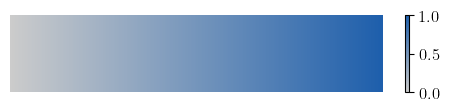

In [4]:
colors = [prior_c, astro_c]
gpn_cmap = LinearSegmentedColormap.from_list("gray_to_blue", colors)

# Display the colormap
gradient = np.linspace(0, 1, 256).reshape(1, -1)
plt.figure(figsize=(6, 1))
plt.imshow(gradient, aspect="auto", cmap=gpn_cmap)
plt.colorbar()
plt.axis("off")
plt.show()

In [5]:
def rescale(weight, vmin=1e-5):
    if weight < vmin:
        return 0
    else:
        log_weight = np.log10(weight)
        return (log_weight-np.log10(vmin))/(0-np.log10(vmin))

In [6]:
collated_eos_gp2 = pd.read_csv(
    '../data/eos-draws-modified/gp2/eos-draws-modified-gp2.csv'
)

astro_weights_gp2 = np.exp(
    collated_eos_gp2.logweight_total - collated_eos_gp2.logweight_total.max()
).values
astro_weights_gp2 /= max(astro_weights_gp2)

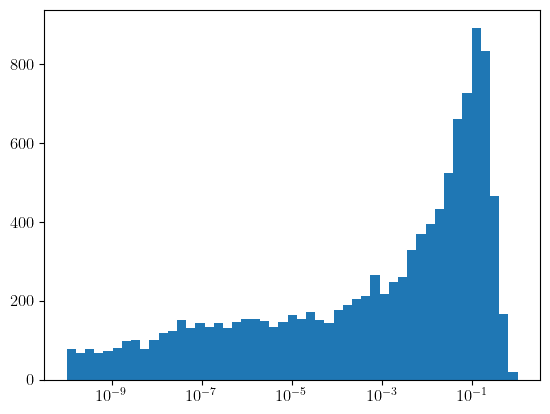

In [7]:
l = 0
number = 25000

gp2_astro_weights_sample = astro_weights_gp2[l:l+number]
gp2_astro_weights_sample /= max(gp2_astro_weights_sample)

fig, ax = plt.subplots()
bins = np.logspace(-10, 0, 50)
ax.hist(gp2_astro_weights_sample, bins=bins)
ax.set_xscale('log')

In [8]:
pqcd_region_dict = pqcd.get_pqcd_region(mu_low=2.4, mu_high=3, res=200)

In [82]:
mu_intersect = []

for i, n in enumerate(collated_eos_gp2.eos.iloc[l:l+number]):

    df = pd.read_csv(
        '../data/eos-draws-modified/gp2/margagn/'
        f'DRAWmod1000-{int(n)//1000:06}/eos-draw-{int(n):06}.csv'
    )

    pressure = to_GeV_per_cubic_femtometre(df.pressurec2)
    energy_density = to_GeV_per_cubic_femtometre(df.energy_densityc2)
    number_density = to_nucleons_per_cubic_femtometre(df.baryon_density)
    chemical_potential = (energy_density+pressure)/number_density

    # Interpolate over chemical potential
    interp_array = pqcd_region_dict['mu_array'][
        (min(chemical_potential) < pqcd_region_dict['mu_array']) &
        (max(chemical_potential) > pqcd_region_dict['mu_array'])
    ]
    pressure_interp = np.interp(interp_array, chemical_potential, pressure)
    number_density_interp = np.interp(
        interp_array, chemical_potential, number_density
    )

    inside_region_n = []
    inside_region_p = []
    inside_region_mu = []

    for n, p, mu in zip(
        number_density_interp, pressure_interp, interp_array
    ):
        if (
            pqcd_region_dict['p_boundary_min'] < p
            < pqcd_region_dict['p_boundary_max']
        ):
            min_n = pqcd_region_dict['left_n_boundary'][
                np.argmin(np.abs(pqcd_region_dict['left_p_boundary']-p))
                ]
            max_n = pqcd_region_dict['right_n_boundary'][
                np.argmin(np.abs(pqcd_region_dict['right_p_boundary']-p))
                ]
            if min_n < n < max_n:
                inside_region_n.append(n)
                inside_region_p.append(p)
                inside_region_mu.append(mu)

    # Find the location where the EOS crosses the surface

    # Variable to keep track of the smallest distance between our EOS and 
    # the PQCD boundary
    delta = 10

    for n, p, mu in zip(inside_region_n, inside_region_p, inside_region_mu):
        for dense_mu, (dense_p_array, dense_n_array) in pqcd_region_dict['dense_arrays'].items():
            distances = (dense_n_array-n)**2 + (dense_p_array-p)**2 + (dense_mu-mu)**2
            near_point_index = np.argmin(distances)
            proposed_delta = distances[near_point_index]
            if proposed_delta < delta:
                delta = proposed_delta
                near_point = (dense_n_array[near_point_index], dense_p_array[near_point_index], dense_mu)

    mu_intersect.append(near_point[2])

In [9]:
mu_intersect = np.loadtxt('../data/eos-draws-modified/gp2/mu_intersect.dat')

(0.8487046789974074, 3.102442634333457)
(-0.48567700045791573, 11.252873457326771)


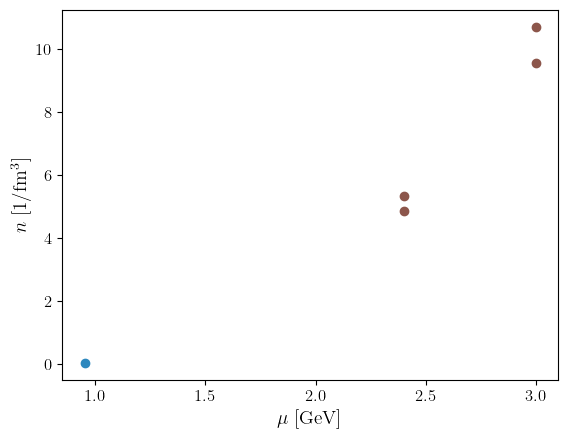

In [10]:
fig, ax = plt.subplots()

X_list = [0.5, 2]
muH_list = [2.4, 3.0]

dense_mu = np.linspace(muL, 3.0, num=5000)

ax.plot(muL, nL, 'o', c=L_c, zorder=10, clip_on=False)

for X in X_list:
    for muH in muH_list:

        pQCDX = pqcd.pQCD(X)
        nH, pH = pQCDX.nH(muH), pQCDX.pH(muH)
        epsilonH = pqcd.epsilon_func(muH, nH, pH)

        constraints = pqcd.constraints(muL, nL, pL, muH, nH, pH)
        mu_array = np.linspace(muL, muH, 1000)

        ax.plot(constraints.muH, constraints.nH, 'o', c='C5', zorder=11, clip_on=False)

# ---

print(ax.get_xlim())
print(ax.get_ylim())

ax.set_xlabel('$\mu$ [GeV]')
ax.set_ylabel('$n$ [1/fm$^3$]');

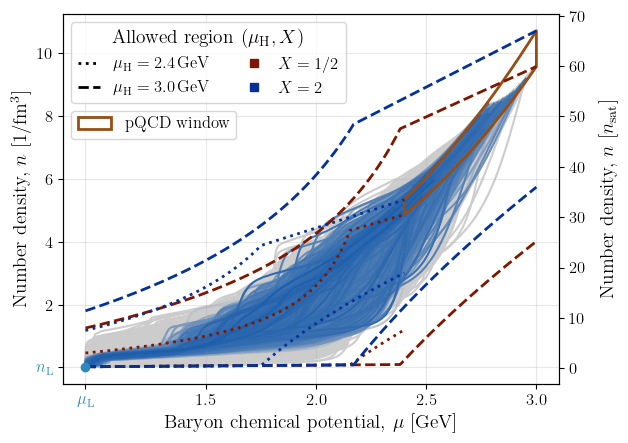

In [11]:
fig, ax = plt.subplots()

ax.set_axisbelow(True)
ax.grid(alpha=0.3)

xlim = (0.8487046789974074, 3.102442634333457)
ylim = (-0.48567700045791573, 11.252873457326771)

X_list = [0.5, 2]
muH_list = [2.4, 3.0]

dense_mu = np.linspace(muL, 3.0, num=5000)

ax.plot(muL, nL, 'o', c=L_c, zorder=10, clip_on=False)

for X in X_list:
    for muH in muH_list:

        pQCDX = pqcd.pQCD(X)
        nH, pH = pQCDX.nH(muH), pQCDX.pH(muH)
        epsilonH = pqcd.epsilon_func(muH, nH, pH)

        constraints = pqcd.constraints(muL, nL, pL, muH, nH, pH)
        mu_array = np.linspace(muL, muH, 1000)
        
        if muH == 2.4:
            ls = ':'
        else:
            ls = '--'

        if X == 0.5:
            c = X05_c
        else:
            c = X2_c

        alpha = 1
        lw = 2

        ax.plot(
            mu_array, 
            constraints.nmin(mu_array), 
            c=c, 
            ls=ls, 
            lw=lw,
            alpha=alpha, 
            zorder=9
        )
        ax.plot(
            mu_array, 
            constraints.nmax(mu_array), 
            c=c, 
            ls=ls, 
            lw=lw,
            alpha=alpha,
            zorder=9
        )

# Draws

for i, n in enumerate(collated_eos_gp2.eos.iloc[l:l+number]):

    df = pd.read_csv(
        '../data/eos-draws-modified/gp2/margagn/'
        f'DRAWmod1000-{int(n)//1000:06}/eos-draw-{int(n):06}.csv'
    )

    pressure = to_GeV_per_cubic_femtometre(df.pressurec2)
    energy_density = to_GeV_per_cubic_femtometre(df.energy_densityc2)
    number_density = to_nucleons_per_cubic_femtometre(df.baryon_density)
    chemical_potential = (energy_density+pressure)/number_density

    pressure_interp = np.interp(dense_mu, chemical_potential, pressure)
    number_density_interp = np.interp(
        dense_mu, chemical_potential, number_density
    )

    weight = rescale(gp2_astro_weights_sample[i], vmin=1e-2)

    if weight < 1e-2:
        rasterized = True
    else:
        rasterized = False

    ax.plot(
        dense_mu[dense_mu < mu_intersect[i]],
        number_density_interp[dense_mu < mu_intersect[i]],
        c=gpn_cmap(weight),
        zorder=weight,
        rasterized=rasterized
    )

ax.plot(
    np.hstack([
        pqcd_region_dict['mu_array'],
        pqcd_region_dict['mu_array'][::-1], 
        [2.4]
    ]),
    np.hstack([
        pqcd_region_dict['left_n_boundary'][200:], 
        pqcd_region_dict['right_n_boundary'][:200][::-1],
        pqcd_region_dict['left_n_boundary'][200]
    ]),
    c=H_c,
    zorder=8,
    lw=2
)

# ---

ax.set_xlim(xlim)
ax.set_ylim(ylim)

twinx = ax.twinx()
twinx.set_ylim(np.array(ax.get_ylim())/nsat)
twinx.set_ylabel('Number density, $n\ [n_\mathrm{sat}]$', labelpad=10)

ax.set_xlabel('Baryon chemical potential, $\mu$ [GeV]')
ax.set_ylabel('Number density, $n$ [1/fm$^3$]')

ax.set_xticks([muL, 1.5, 2.0, 2.5, 3.0])
ax.set_xticklabels(['$\mu_\mathrm{L}$', 1.5, 2.0, 2.5, 3.0])
for i, xtick in enumerate(ax.get_xticklabels()):
    if i == 0:
        xtick.set_color(L_c)

ax.set_yticks([nL, 2, 4, 6, 8, 10])
ax.set_yticklabels(['$n_\mathrm{L}$', 2, 4, 6, 8, 10])
for i, ytick in enumerate(ax.get_yticklabels()):
    if i == 0:
        ytick.set_color(L_c)

custom_handles = [
    mpatches.Patch(
        color=H_c,
        lw=2,
        fill=False
    )
]
custom_labels = [
    'pQCD window'
]
l1 = ax.legend(
    custom_handles,
    custom_labels,
    loc='upper left',
    bbox_to_anchor=(0.0, .761),
)
ax.add_artist(l1)

custom_handles = [
    plt.Line2D(
        [0], [0], color='k', lw=2, ls=':'
    ),
    plt.Line2D(
        [0], [0], color='k', lw=2, ls='--'
    ),
    plt.Line2D(
        [0], [0], color=X05_c, marker='s', lw=0
    ),
    plt.Line2D(
        [0], [0], color=X2_c, marker='s', lw=0
    ),
]
custom_labels = [
    '$\mu_\mathrm{H} = 2.4\,\mathrm{GeV}$',
    '$\mu_\mathrm{H} = 3.0\,\mathrm{GeV}$',
    '$X=1/2$',
    '$X=2$'
]
l2 = ax.legend(
    custom_handles,
    custom_labels,
    loc='upper left',
    bbox_to_anchor=(0.0, 1.0),
    title='Allowed region $(\mu_\mathrm{H},X)$',
    ncol=2,
    handlelength=1.3
)

fig.savefig('figures/paper/unified_mu_n.pdf', dpi=480, bbox_inches='tight')

Text(0.5, 0, '$\\mu$ [GeV]')

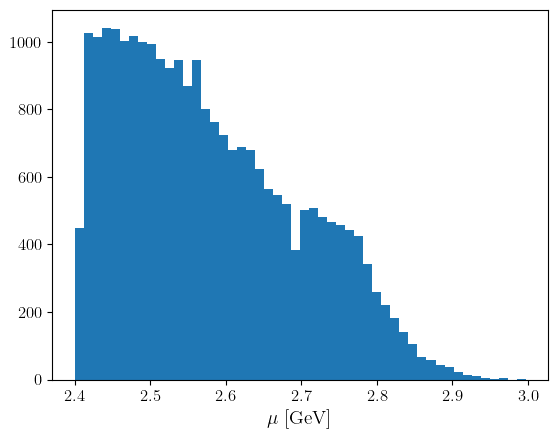

In [12]:
fig, ax = plt.subplots()
ax.hist(mu_intersect, bins=50)
ax.set_xlabel('$\mu$ [GeV]')

In [ ]:
np.savetxt(
    'mu_intersect.dat',
    mu_intersect
)